# Some basic evaluations of the data

### Init and load data

In [1]:
library(tidyverse)

# for Jaccard distance
library(stringdist)

# for sentiment analysis
install.packages('sentimentr')
library(sentimentr)

# load data
t1 <- Sys.time()
df_train <- read.csv('../input/tweet-sentiment-extraction/train.csv')
df_test <- read.csv('../input/tweet-sentiment-extraction/test.csv')
df_sub <- read.csv('../input/tweet-sentiment-extraction/sample_submission.csv')
t2 <- Sys.time()
print(t2-t1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.4     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lexicon’, ‘syuzhet’, ‘textclean’




Time difference of 0.7808897 secs


# Basic Explorations of Training Data

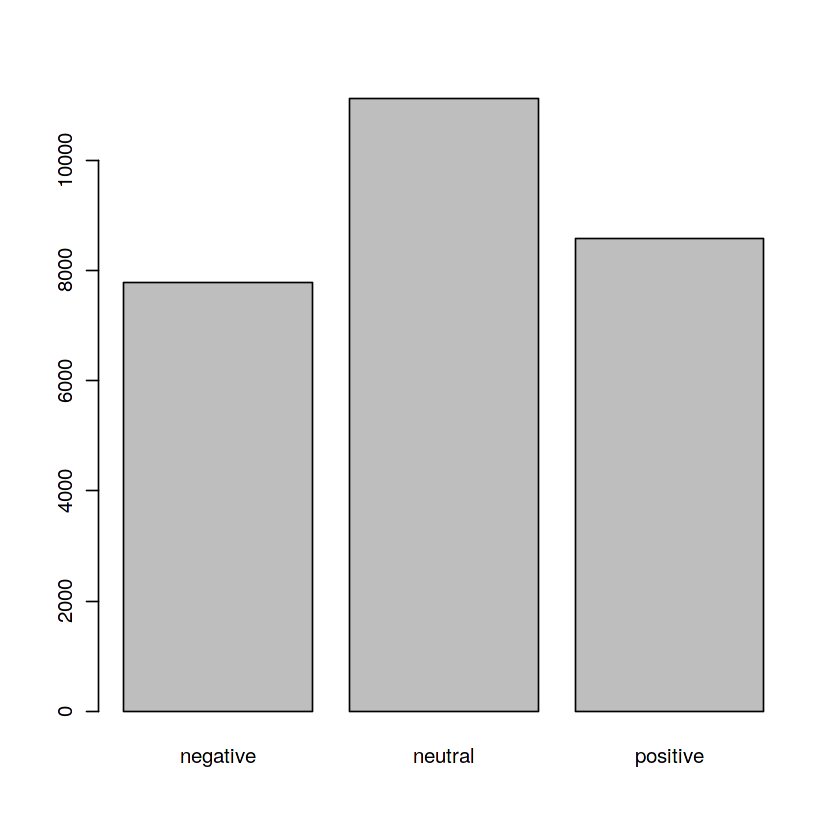

In [2]:
# show distribution of sentiments
df <- df_train
df$sentiment <- as.factor(df$sentiment)
plot(df$sentiment)

In [3]:
# evaluate length of text and selected text
df$text <- as.character(df$text)
df$selected_text <- as.character(df$selected_text)

df$length <- str_length(df$text)
df$length_sel <- str_length(df$selected_text)

In [4]:
# remove empty entries from training
df <- dplyr::filter(df, length > 0)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00   39.00   64.00   68.73   97.00  165.00 

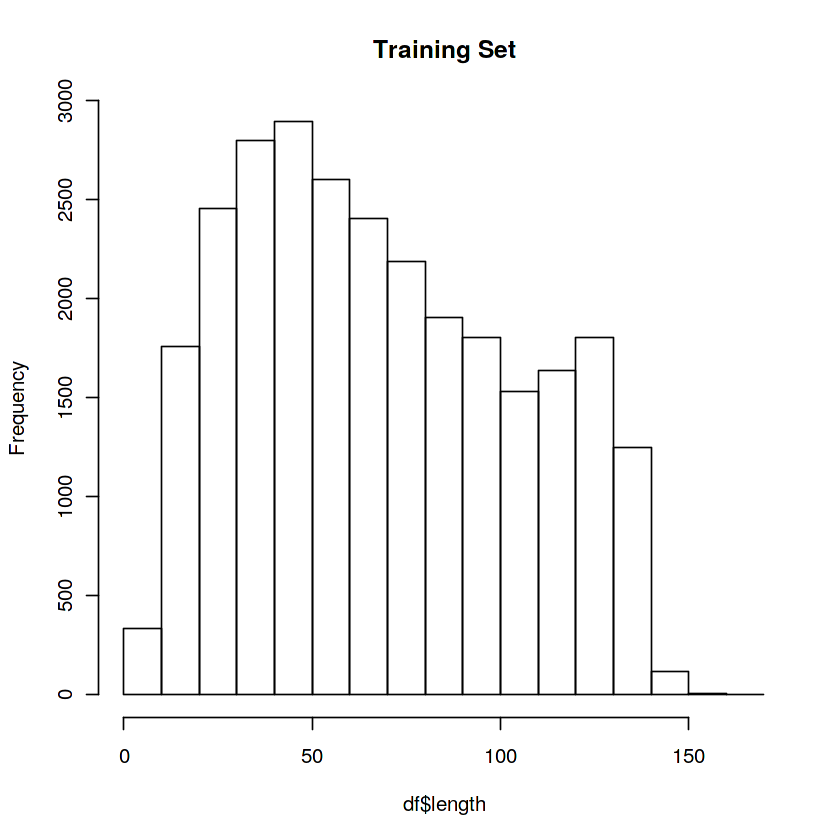

In [5]:
summary(df$length)
hist(df$length, main='Training Set')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    8.00   22.00   36.75   55.00  141.00 

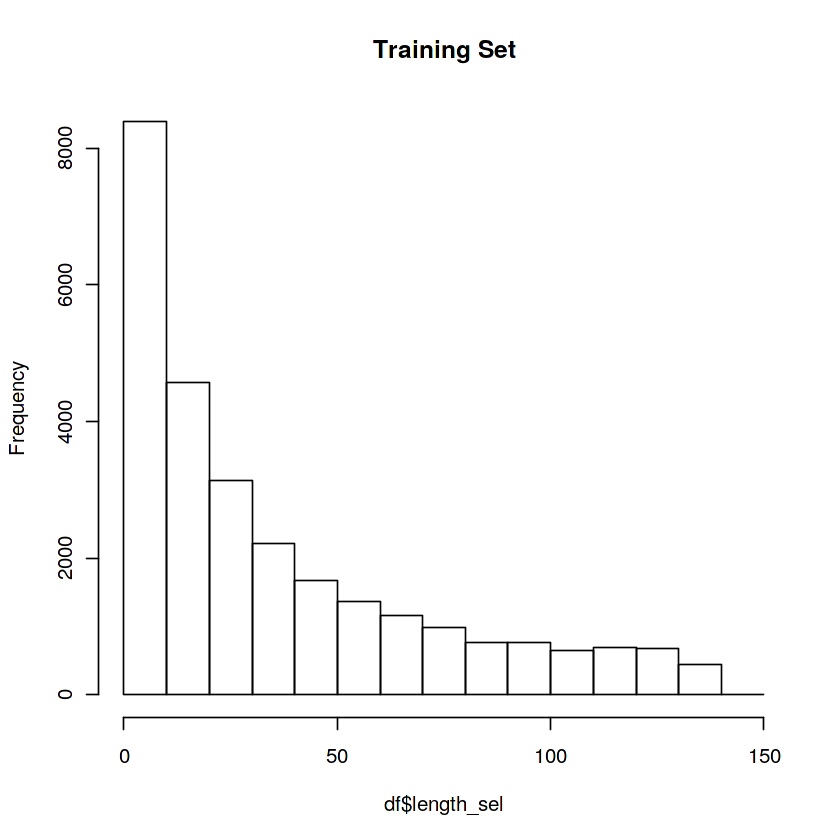

In [6]:
summary(df$length_sel)
hist(df$length_sel, main='Training Set')

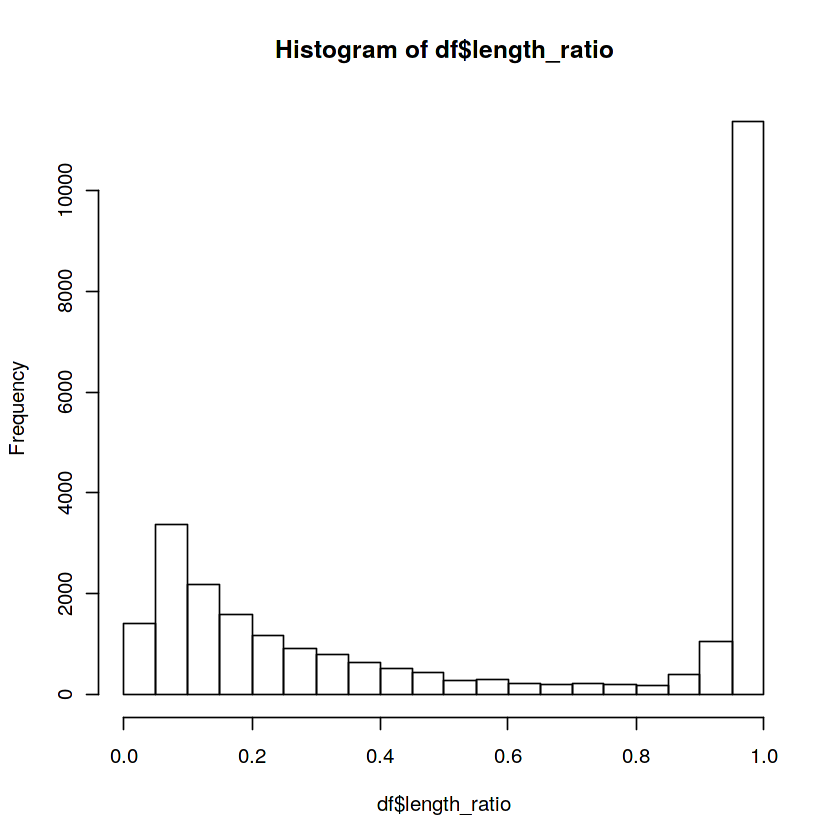

In [7]:
# Ratio of selected text vs full text
df$length_ratio <- df$length_sel / df$length
hist(df$length_ratio)

#### Evaluate (relative) begin and end of selected substring

In [8]:
# Find start and end position of selected text in text
fun_find_first <- function(text, subtext) {
  foo <- stringr::str_locate(text, fixed(subtext))
  return(foo[1])
}

fun_find_second <- function(text, subtext) {
  foo <- stringr::str_locate(text, fixed(subtext))
  return(foo[2])
}

n <- nrow(df)
as <- 1:n
bs <- 1:n

for (i in 1:n) {
  # print(i)
  text <- df$text[i]
  subtext <- df$selected_text[i]
  a <- fun_find_first(text, subtext)
  b <- fun_find_second(text, subtext)
  as[i] <- a
  bs[i] <- b
}

df$begin <- as
df$end <- bs

df$begin_rel <- df$begin / df$length
df$end_rel <- df$end / df$length

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00625 0.02128 0.06061 0.23285 0.42391 1.00000 

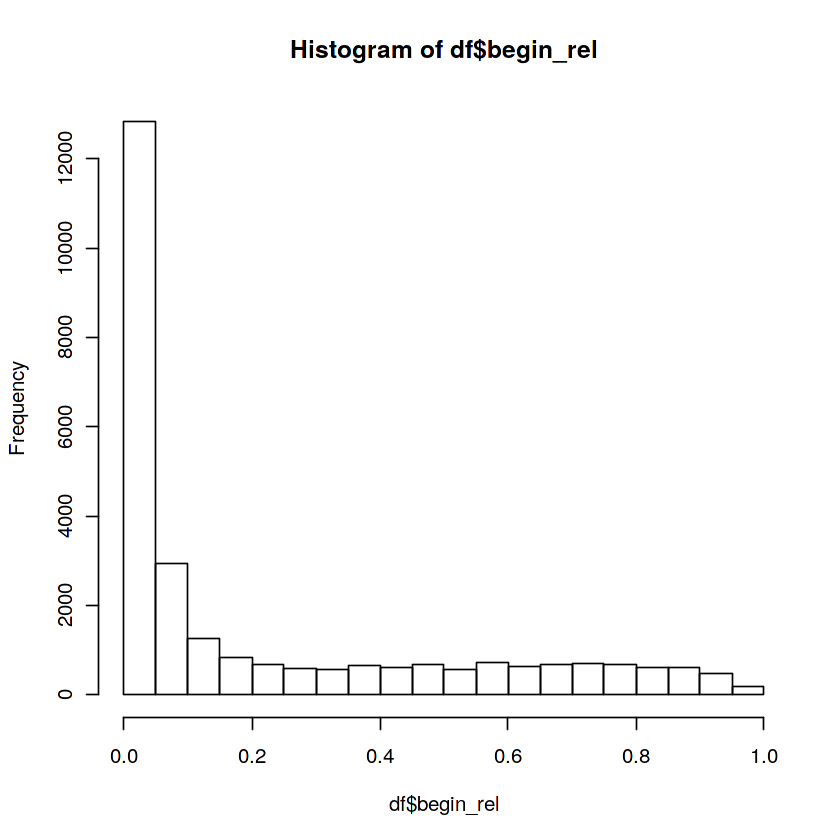

In [9]:
summary(df$begin_rel)
hist(df$begin_rel)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0229  0.5920  1.0000  0.7925  1.0000  1.0000 

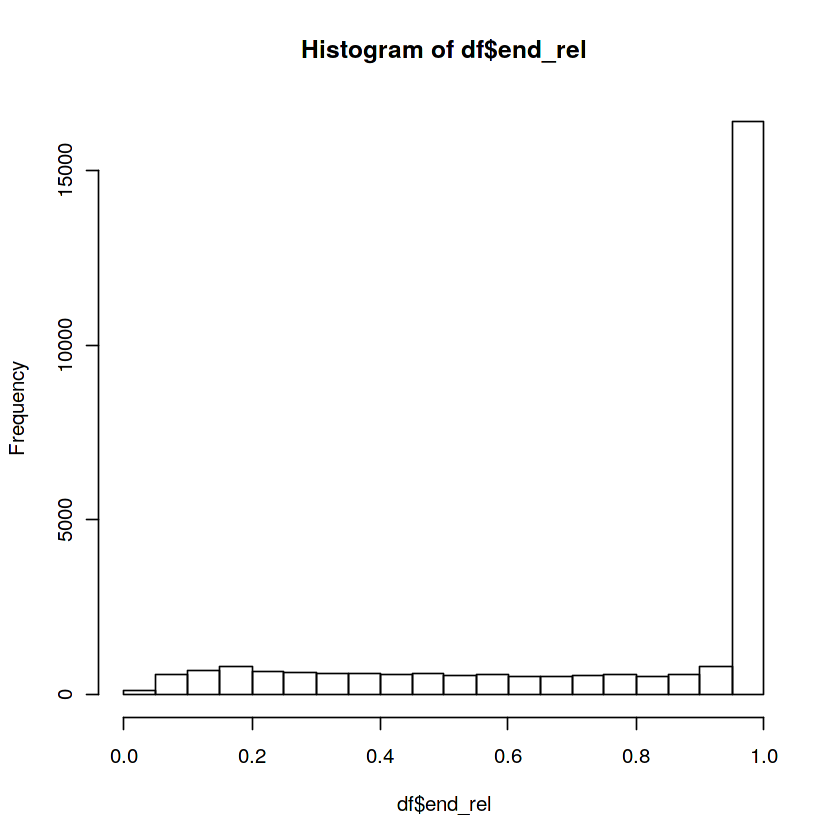

In [10]:
summary(df$end_rel)
hist(df$end_rel)

In [11]:
# Jaccard distances
df$jac <- stringdist::stringdist(df$text, df$selected_text, method='jaccard')
summary(df$jac)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.2000  0.3183  0.6667  0.9730 

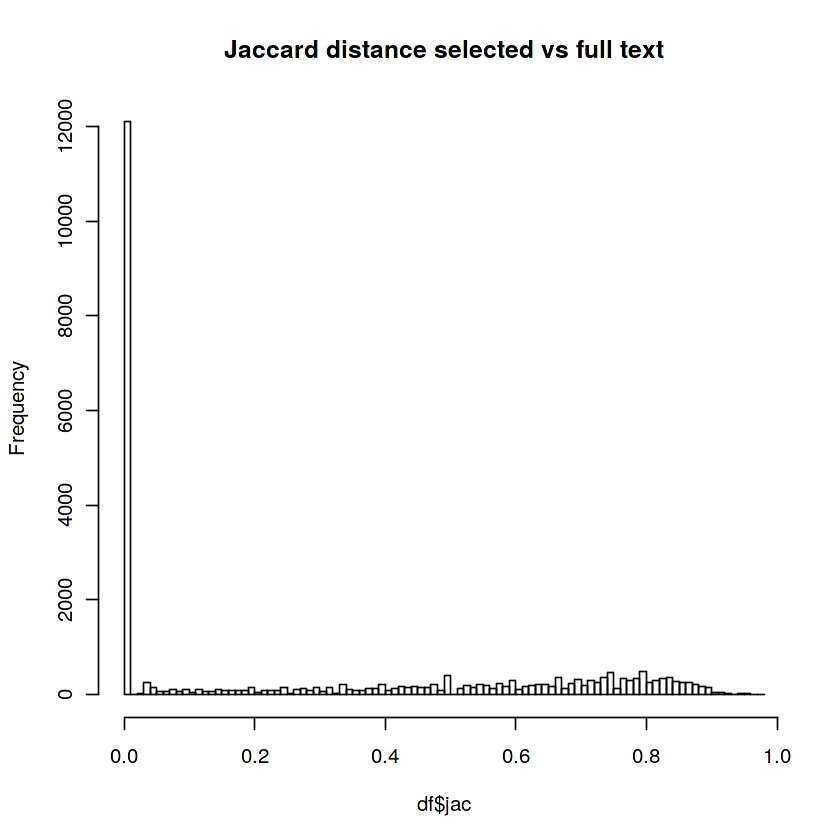

In [12]:
hist(df$jac, 100, main='Jaccard distance selected vs full text')

In [13]:
# sentiment analysis
sentiment_train <- sentimentr::sentiment_by(get_sentences(df$text))
df$sentiment_score <- sentiment_train$ave_sentiment
df$word_count <- sentiment_train$word_count

In [14]:
head(sentiment_train,10)

element_id,word_count,sd,ave_sentiment
<int>,<int>,<dbl>,<dbl>
1,28,0.3391743,0.06965812
2,9,0.1875000,0.14469694
3,13,0.0000000,0.00000000
4,9,0.0000000,0.00000000
5,6,NA,0.12247449
6,5,NA,-0.22360680
7,12,0.2285534,0.33838835
8,11,0.1208750,0.16452847
9,7,0.1443376,0.11138776


In [15]:
# same for selected text
sentiment_train_sel <- sentimentr::sentiment_by(get_sentences(df$selected_text))
df$sentiment_score_sel <- sentiment_train_sel$ave_sentiment
df$word_count_sel <- sentiment_train_sel$word_count


In [16]:
head(sentiment_train_sel,10)

element_id,word_count,sd,ave_sentiment
<int>,<int>,<dbl>,<dbl>
1,10,0.5066321,0.07476967
2,1,NA,0.75000000
3,8,NA,0.00000000
4,7,NA,0.00000000
5,1,NA,0.80000000
6,1,NA,-0.50000000
7,4,NA,0.50000000
8,1,NA,0.25000000
9,1,NA,0.50000000


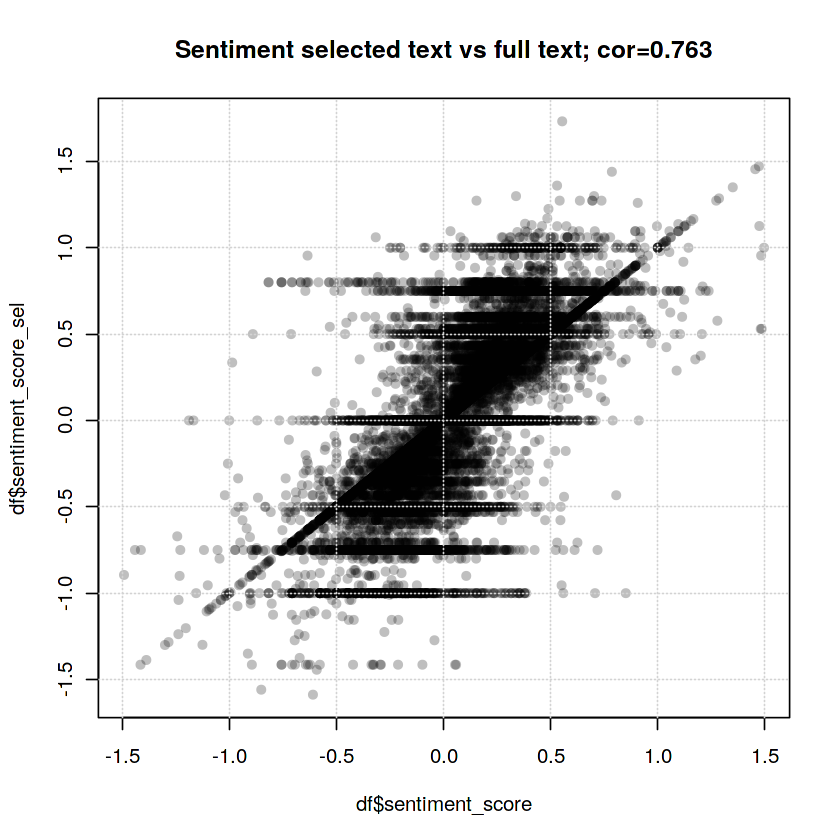

In [17]:
# correlation between sentiment of selected text and full text
sent_cor = round(cor(df$sentiment_score, df$sentiment_score_sel),3)
plot(df$sentiment_score, df$sentiment_score_sel, col='#00000040', pch=16,
    main=paste0('Sentiment selected text vs full text; cor=',sent_cor))
grid()

# Evaluate by Sentiment

In [18]:
stats_train <- dplyr::group_by(df, sentiment) %>% summarise(n=n(),
                                  mean_words = mean(word_count),
                                  mean_words_sel = mean(word_count_sel),
                                  mean_length = mean(length),
                                  mean_length_sel = mean(length_sel),
                                  mean_ratio = mean(length_ratio),
                                  median_ratio = median(length_ratio),
                                  mean_begin_rel = mean(begin_rel),
                                  mean_end_rel = mean(end_rel),
                                  mean_jac = mean(jac),
                                  mean_sentiment_score = mean(sentiment_score),
                                  mean_sentiment_score_sel = mean(sentiment_score_sel)
                                  )
stats_train <- as.data.frame(stats_train)

In [19]:
# show result
stats_train

sentiment,n,mean_words,mean_words_sel,mean_length,mean_length_sel,mean_ratio,median_ratio,mean_begin_rel,mean_end_rel,mean_jac,mean_sentiment_score,mean_sentiment_score_sel
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
negative,7786,13.47521,3.906370,70.81146,19.99846,0.3388579,0.2058824,0.36976786,0.6882884,0.50450807,-0.13928150,-0.34155829
neutral,11117,12.43978,12.058559,65.60601,62.83125,0.9600658,1.0000000,0.04839204,0.9840070,0.02082943,0.04208433,0.04225852
positive,8582,13.21965,3.503379,70.88126,18.15672,0.3117370,0.1777778,0.34758637,0.6390357,0.53479758,0.25109796,0.43592583


In [20]:
df_train_neutral <- dplyr::filter(df, sentiment=='neutral')
df_train_positive <- dplyr::filter(df, sentiment=='positive')
df_train_negative <- dplyr::filter(df, sentiment=='negative')

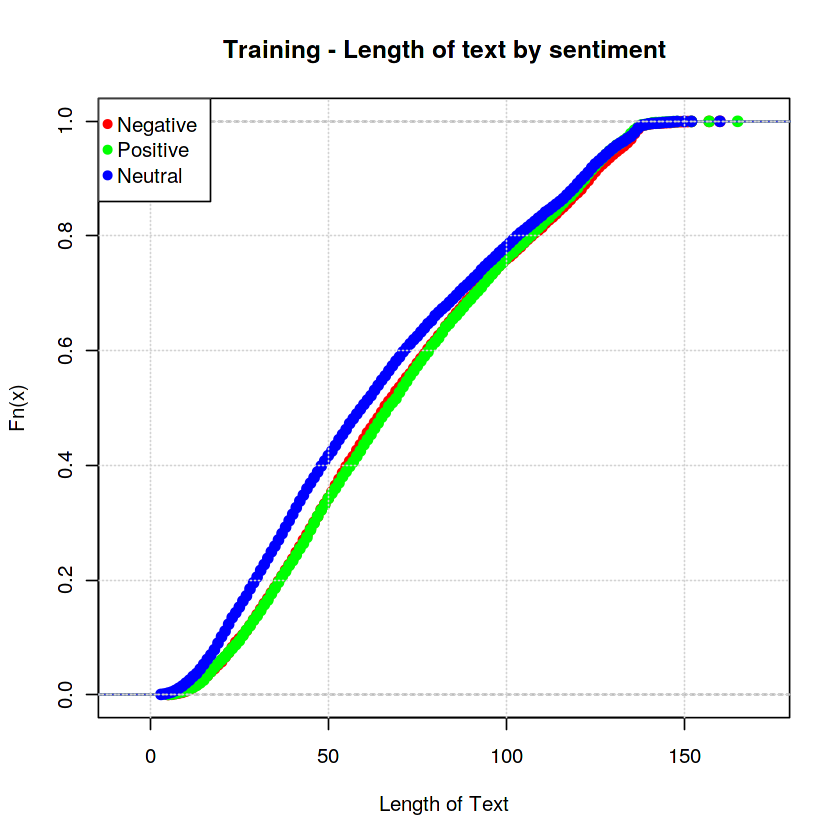

In [21]:
plot(ecdf(df_train_negative$length), col='red', main='Training - Length of text by sentiment', xlab='Length of Text')
plot(ecdf(df_train_positive$length), col='green', add=TRUE)
plot(ecdf(df_train_neutral$length), col='blue', add=TRUE)
grid()
legend('topleft', text.width=25, legend=c('Negative','Positive','Neutral'), col=c('red','green','blue'), pch=16)

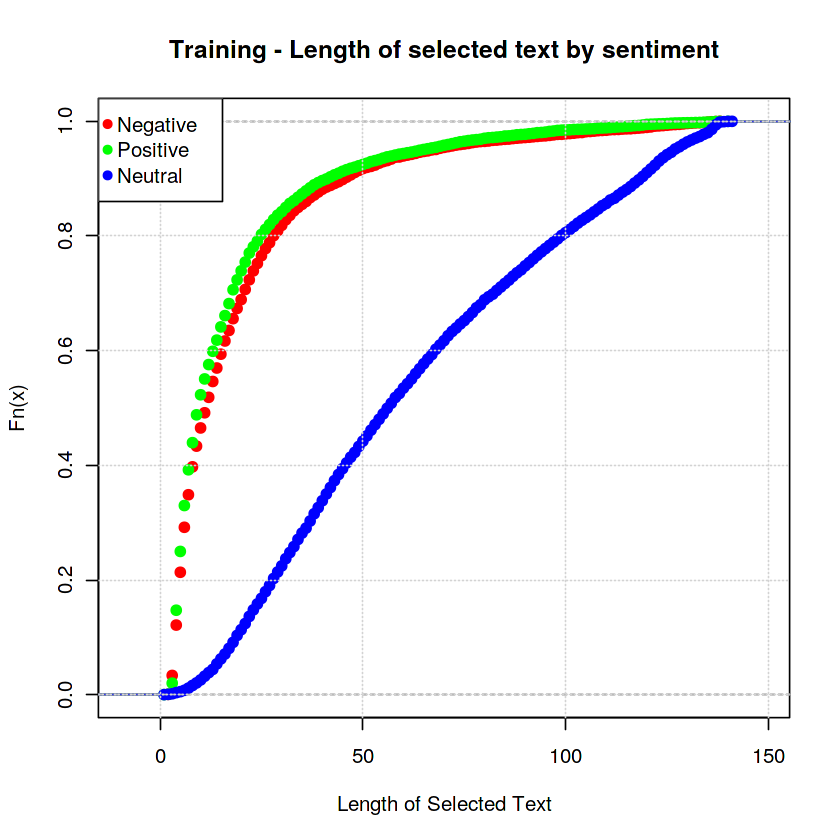

In [22]:
plot(ecdf(df_train_negative$length_sel), col='red', main='Training - Length of selected text by sentiment', xlab='Length of Selected Text')
plot(ecdf(df_train_positive$length_sel), col='green', add=TRUE)
plot(ecdf(df_train_neutral$length_sel), col='blue', add=TRUE)
grid()
legend('topleft', text.width=25, legend=c('Negative','Positive','Neutral'), col=c('red','green','blue'), pch=16)

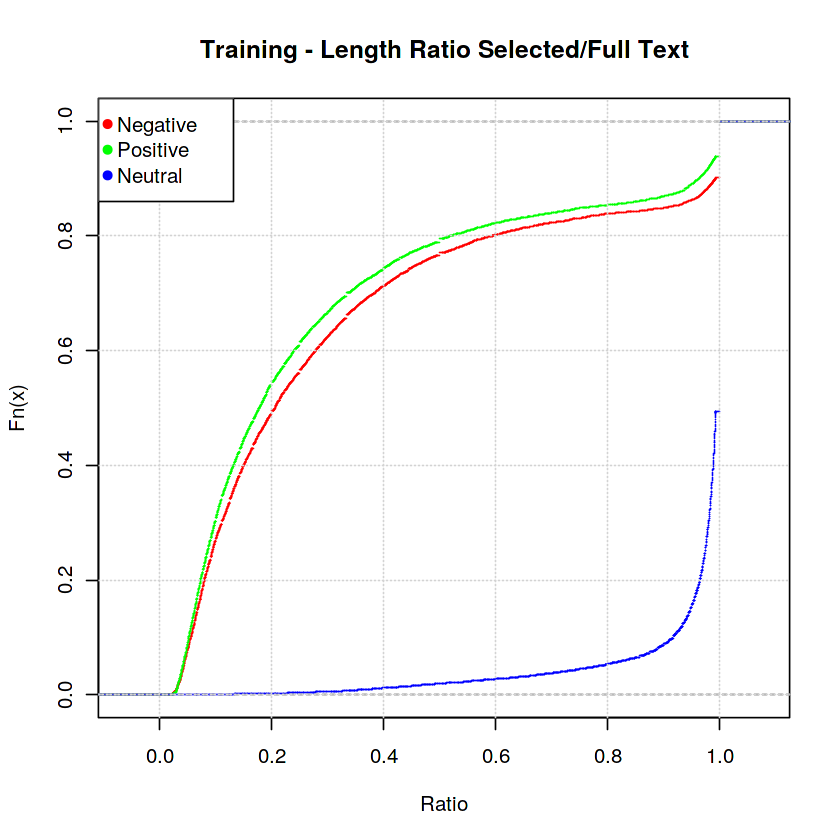

In [23]:
plot(ecdf(df_train_negative$length_ratio), col='red', main='Training - Length Ratio Selected/Full Text', xlab='Ratio')
plot(ecdf(df_train_positive$length_ratio), col='green', add=TRUE)
plot(ecdf(df_train_neutral$length_ratio), col='blue', add=TRUE)
grid()
legend('topleft', text.width=0.2, legend=c('Negative','Positive','Neutral'), col=c('red','green','blue'), pch=16)

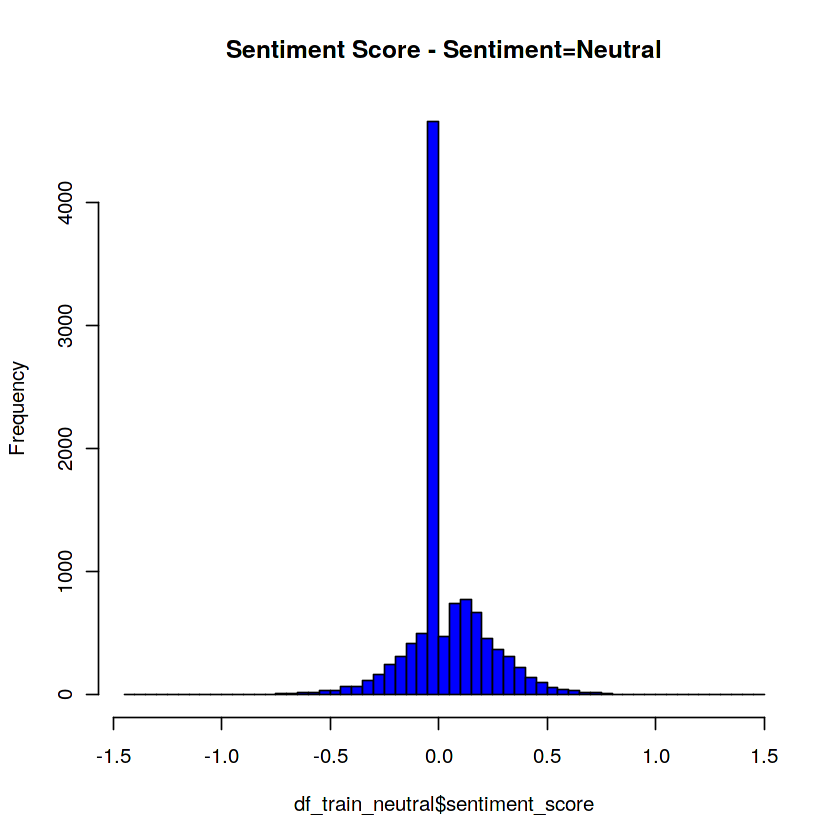

In [24]:
hist(df_train_neutral$sentiment_score, 50, col='blue', main='Sentiment Score - Sentiment=Neutral')

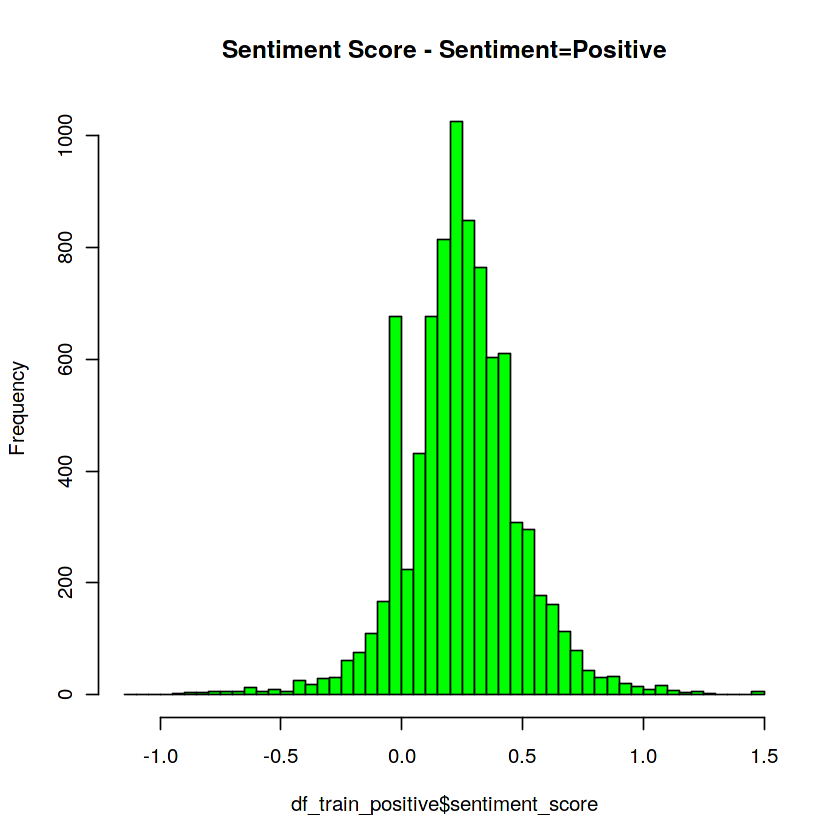

In [25]:
hist(df_train_positive$sentiment_score, 50, col='green', main='Sentiment Score - Sentiment=Positive')

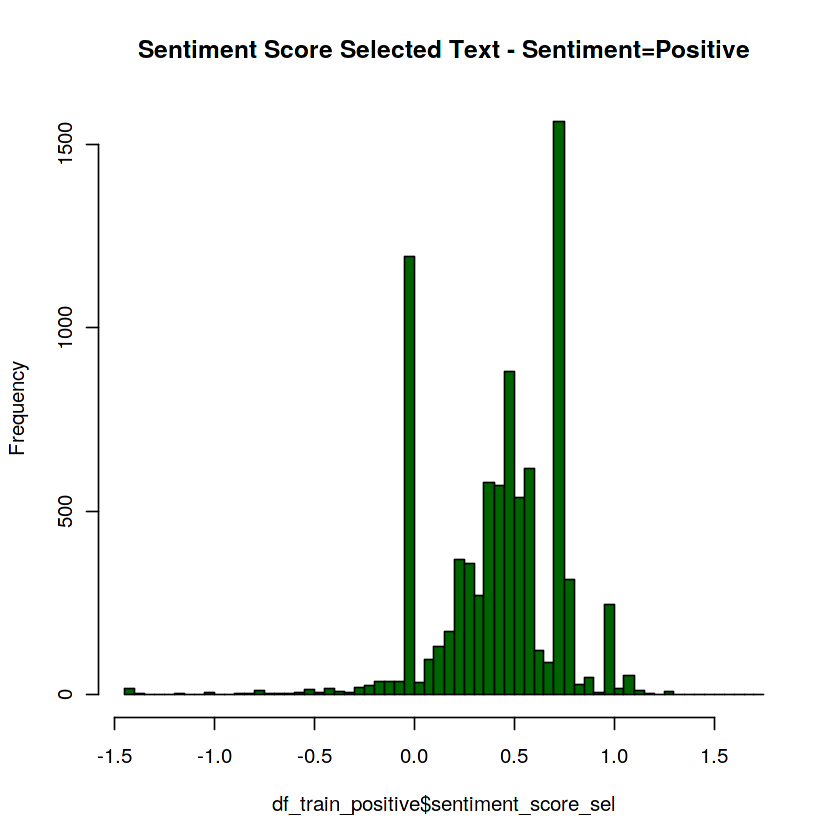

In [26]:
hist(df_train_positive$sentiment_score_sel, 50, col='darkgreen', main='Sentiment Score Selected Text - Sentiment=Positive')

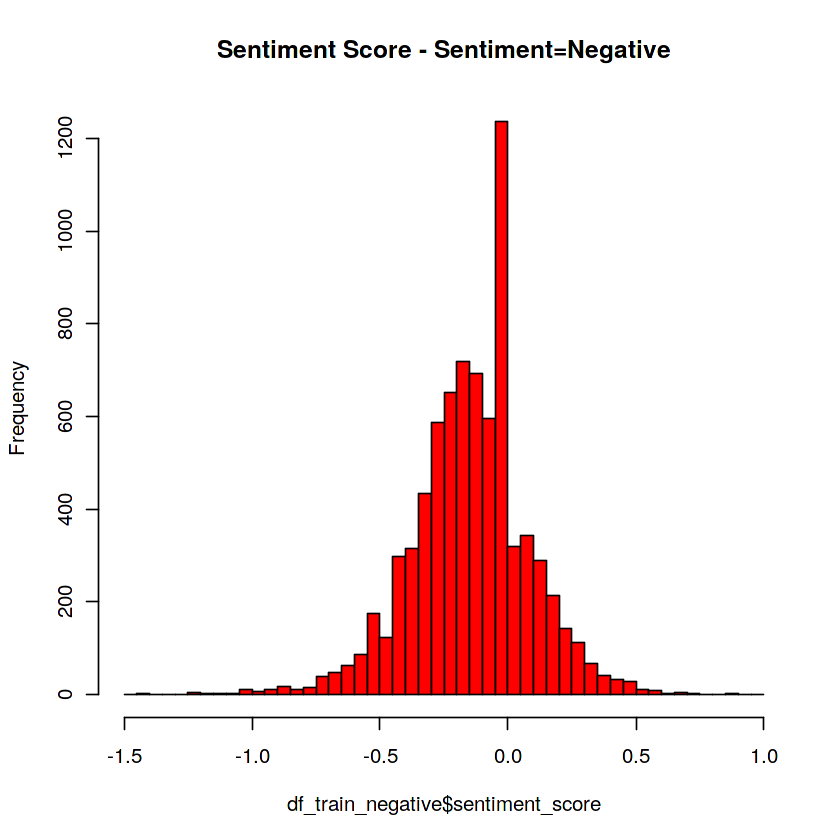

In [27]:
hist(df_train_negative$sentiment_score, 50, col='red', main='Sentiment Score - Sentiment=Negative')

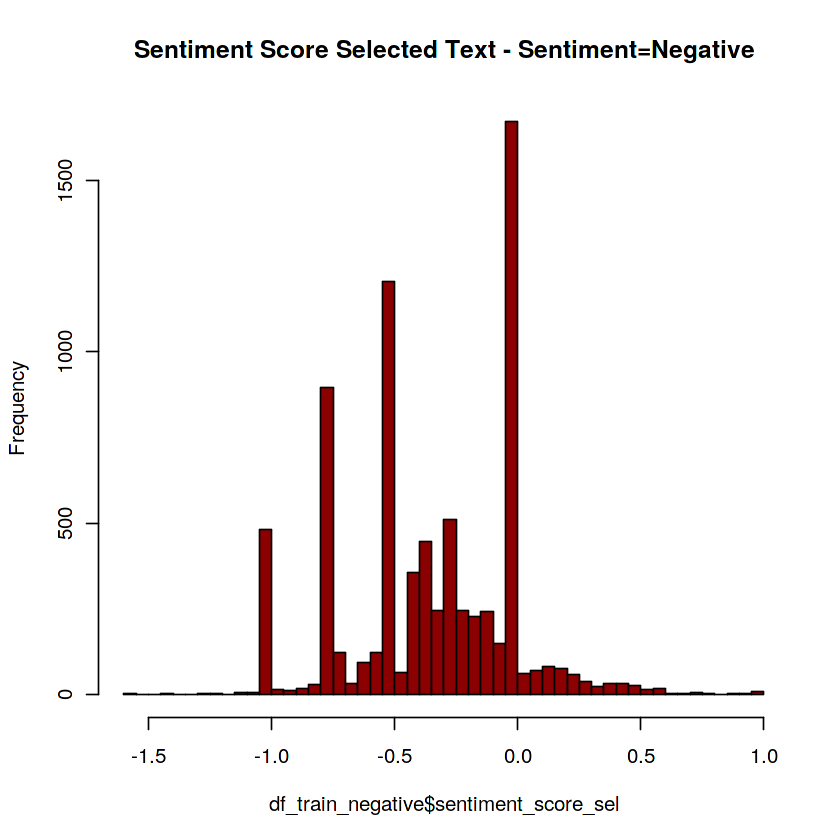

In [28]:
hist(df_train_negative$sentiment_score_sel, 50, col='darkred', main='Sentiment Score Selected Text - Sentiment=Negative')

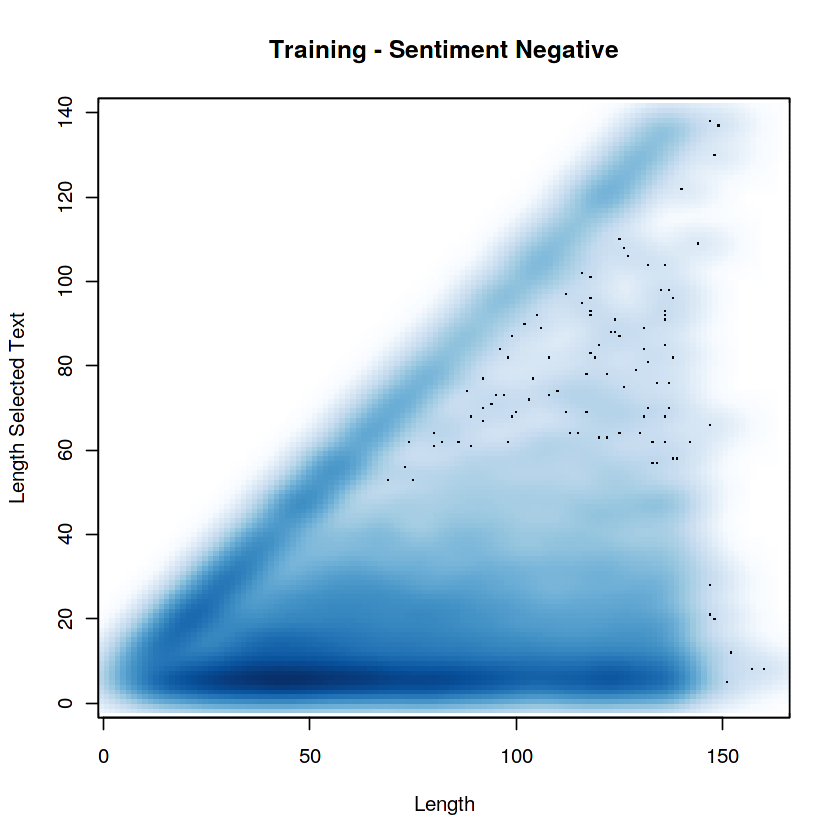

In [29]:
smoothScatter(df_train_negative$length, df_train_negative$length_sel, xlab='Length', ylab='Length Selected Text',
             main='Training - Sentiment Negative')

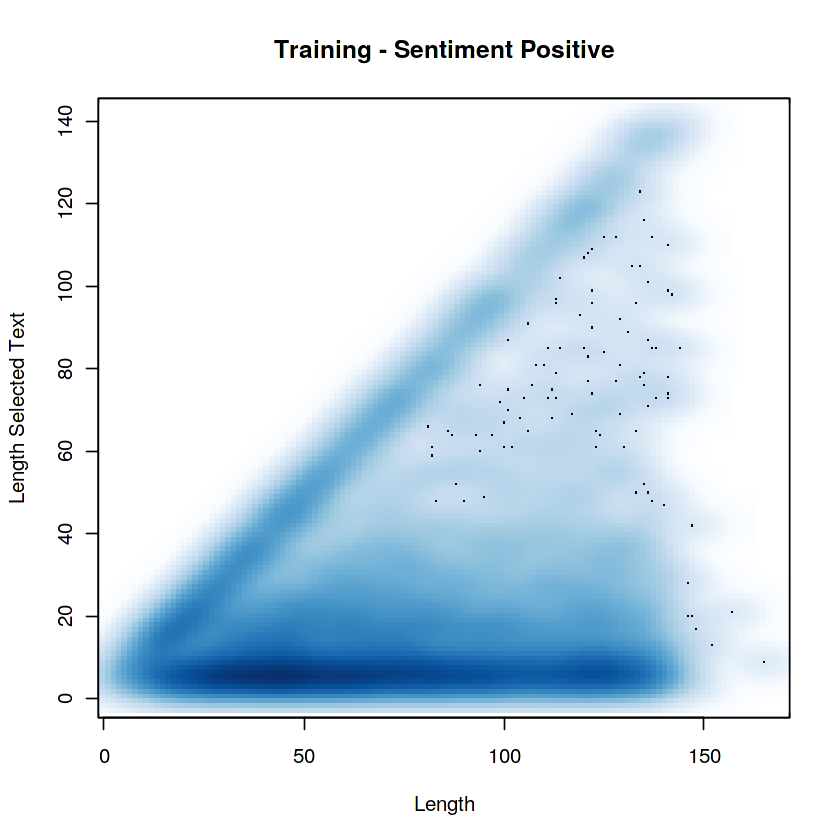

In [30]:
smoothScatter(df_train_positive$length, df_train_positive$length_sel, xlab='Length', ylab='Length Selected Text',
             main='Training - Sentiment Positive')

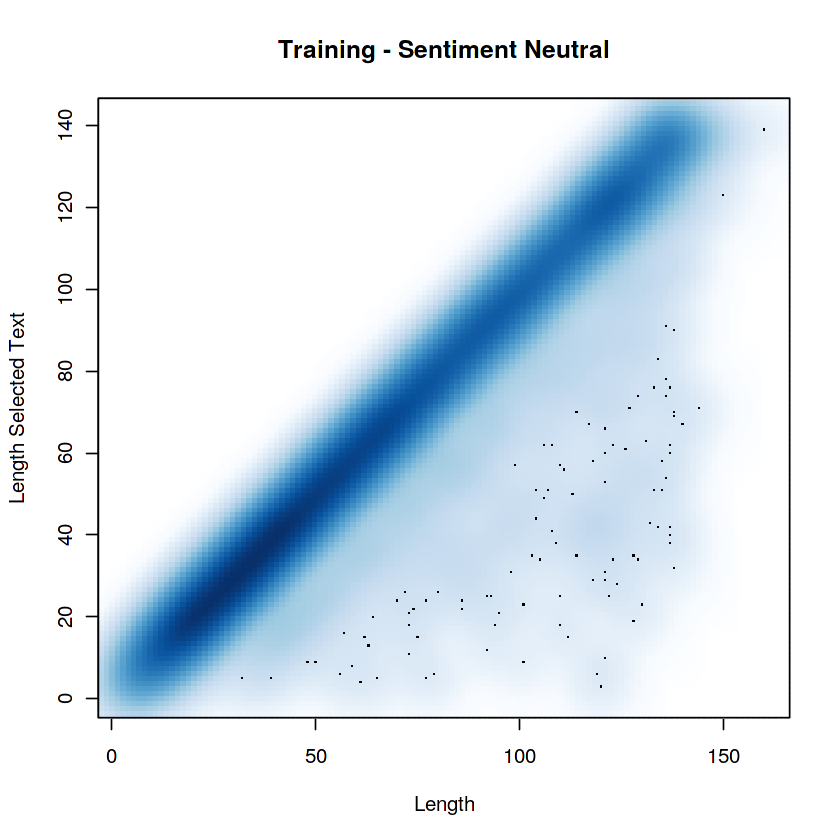

In [31]:
smoothScatter(df_train_neutral$length, df_train_neutral$length_sel, xlab='Length', ylab='Length Selected Text',
             main='Training - Sentiment Neutral')

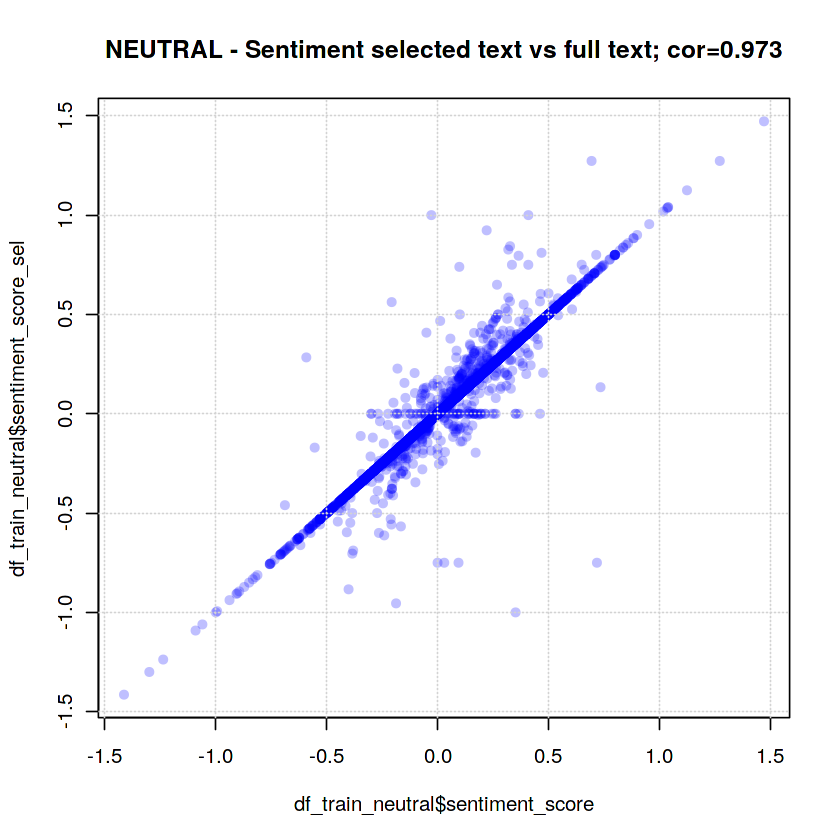

In [32]:
sent_cor = round(cor(df_train_neutral$sentiment_score, df_train_neutral$sentiment_score_sel),3)
plot(df_train_neutral$sentiment_score, df_train_neutral$sentiment_score_sel, col='#0000ff40', pch=16,
    main=paste0('NEUTRAL - Sentiment selected text vs full text; cor=',sent_cor))
grid()

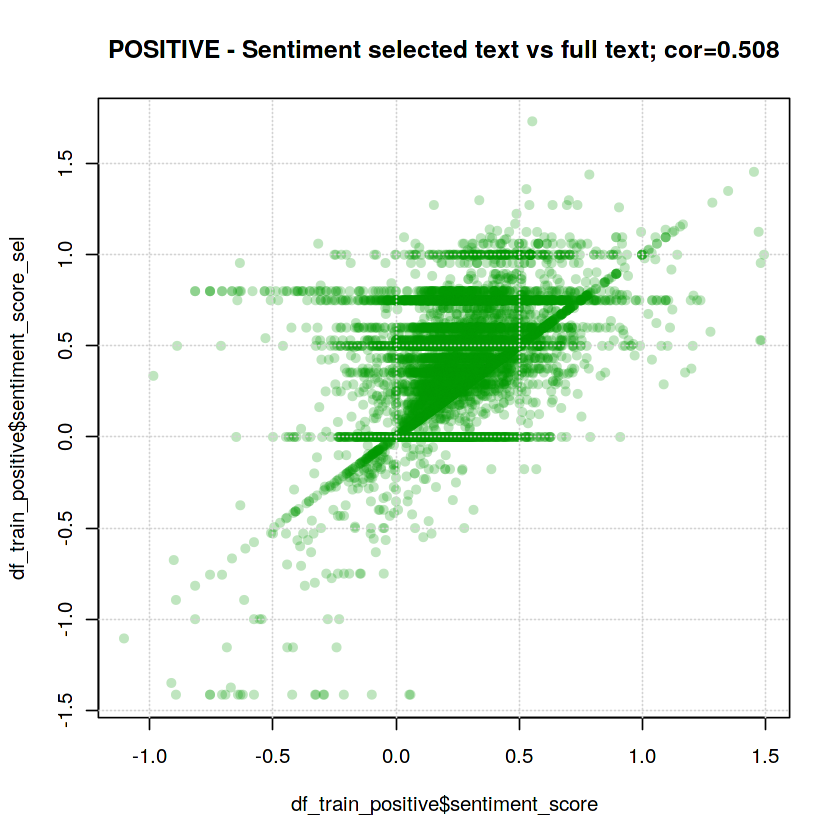

In [33]:
sent_cor = round(cor(df_train_positive$sentiment_score, df_train_positive$sentiment_score_sel),3)
plot(df_train_positive$sentiment_score, df_train_positive$sentiment_score_sel, col='#00990040', pch=16,
    main=paste0('POSITIVE - Sentiment selected text vs full text; cor=',sent_cor))
grid()

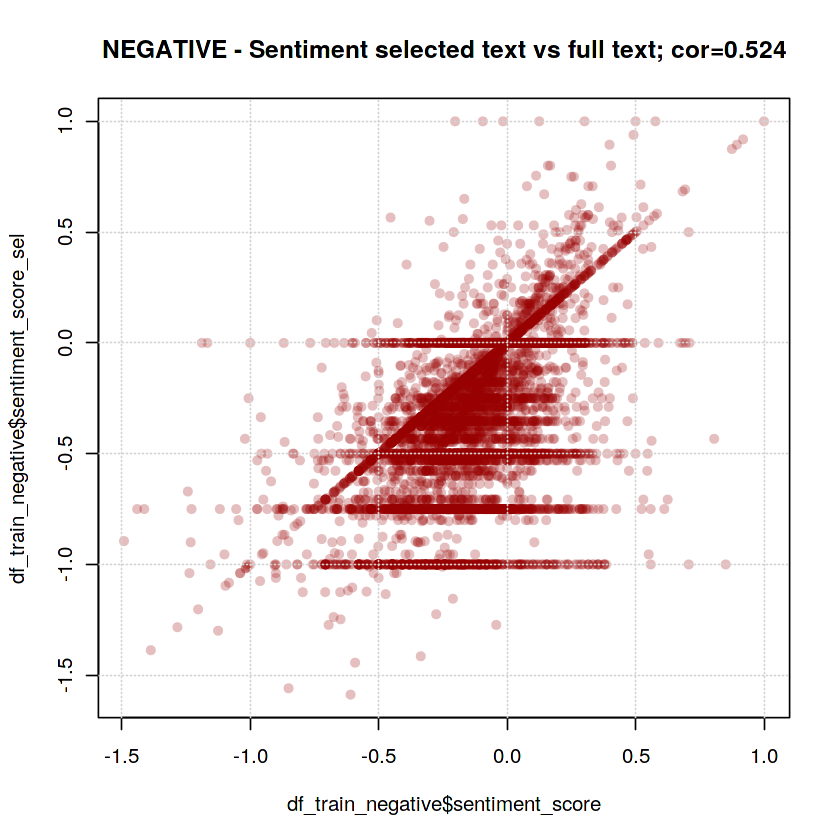

In [34]:
sent_cor = round(cor(df_train_negative$sentiment_score, df_train_negative$sentiment_score_sel),3)
plot(df_train_negative$sentiment_score, df_train_negative$sentiment_score_sel, col='#99000040', pch=16,
    main=paste0('NEGATIVE - Sentiment selected text vs full text; cor=',sent_cor))
grid()

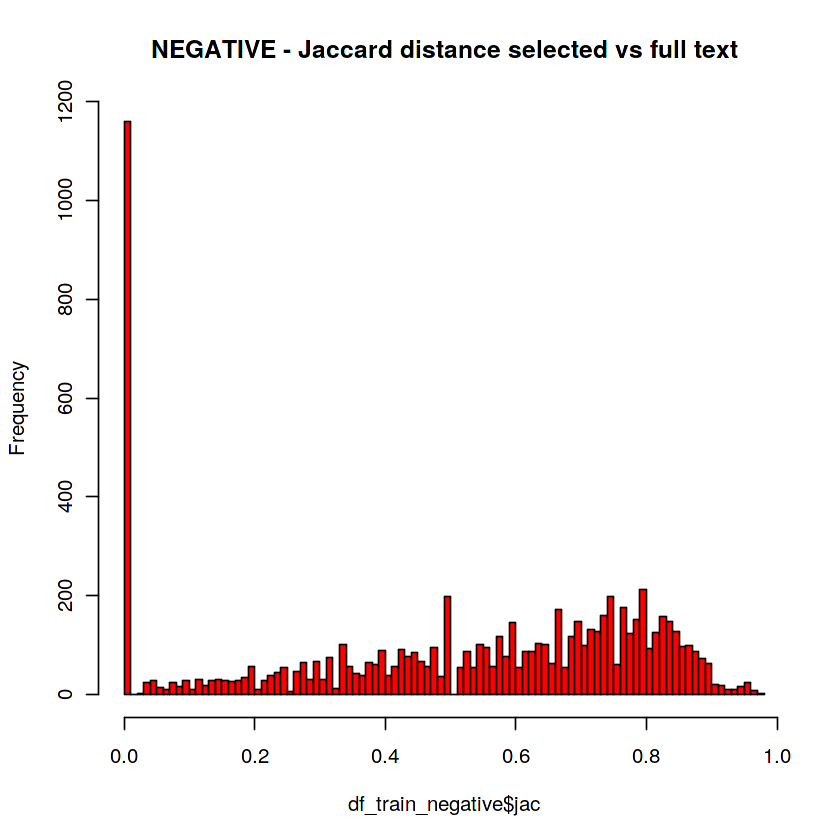

In [35]:
hist(df_train_negative$jac,100, main='NEGATIVE - Jaccard distance selected vs full text', col='red')

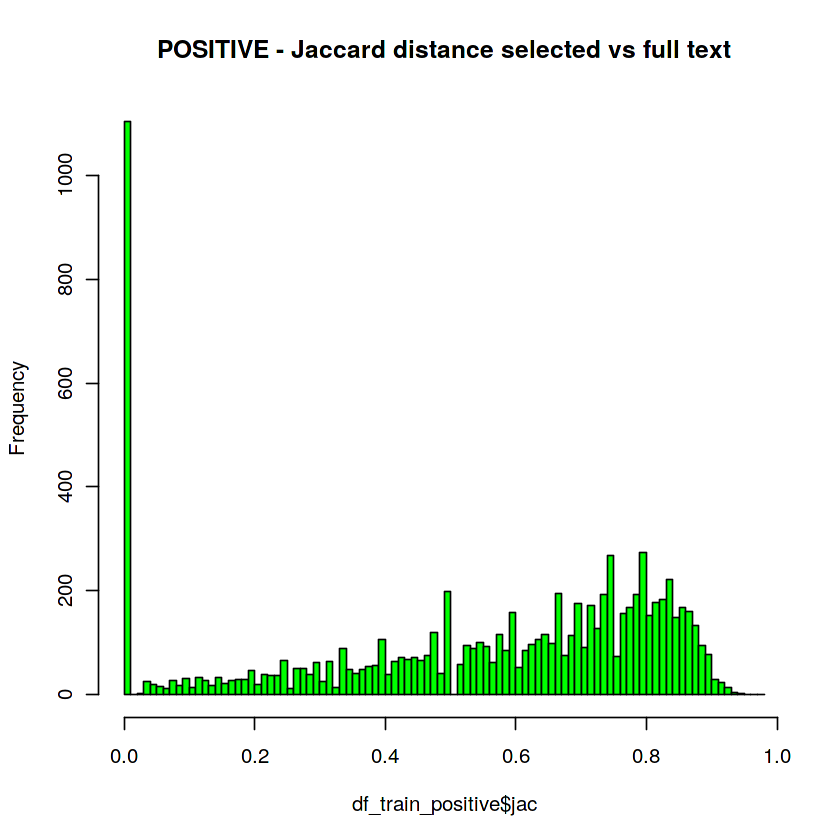

In [36]:
hist(df_train_positive$jac,100, main='POSITIVE - Jaccard distance selected vs full text', col='green')

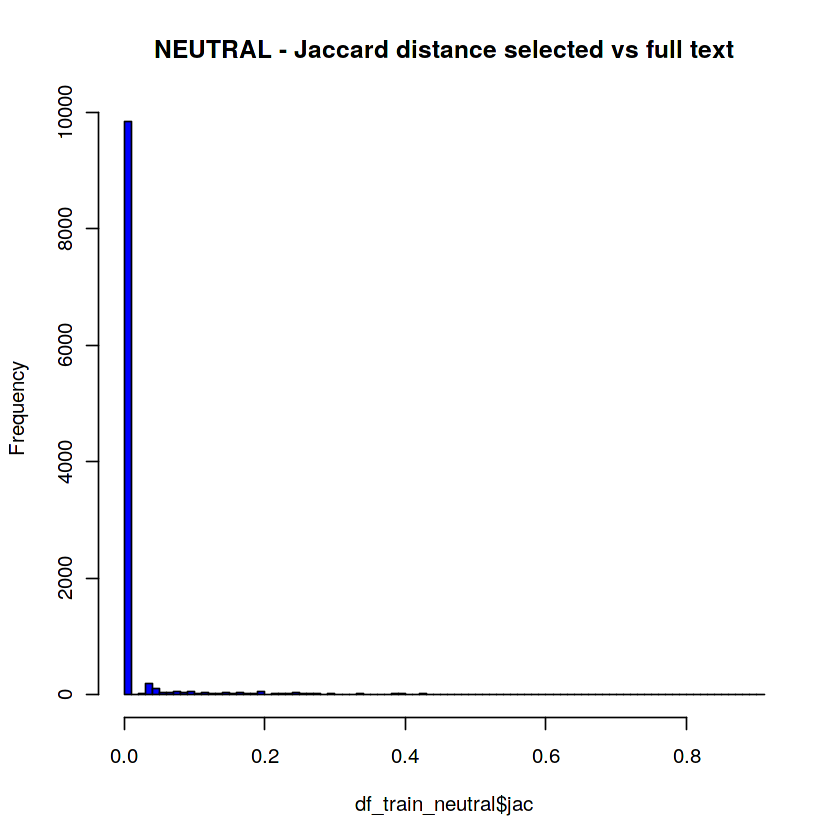

In [37]:
hist(df_train_neutral$jac,100, main='NEUTRAL - Jaccard distance selected vs full text', col='blue')